# Quantum Alternating Operator Ansatz (QAOA) on the Max-κ-Colorable Subgraph problem

In this example, we implement QAOA for the Max-κ-Colorable Subgraph problem (also known as Max-κ-Cut).

Reference:

- Stuart Hadfield, Zhihui Wang, Bryan O'Gorman, Eleanor G. Rieffel,Davide Venturelli and Rupak Biswas. From the Quantum Approximate Optimization Algorithm to a Quantum Alternating Operator Ansatz. Algorithms 12.2 (2019), p.34.

The code is also available as a standalone repo at https://github.com/Vuenc/QAOA-Mixers, which additionally includes code to run experiments in an automated fashion.

In [1]:
# Importing the required libraries
using Qaintessent
using Qaintellect
using LinearAlgebra
using Flux
using Plots

# Importing some example-specific utility functions for printing/plotting the output distribution
include("qaoa_max_k_col_subgraph_utility.jl");

## Quantum Alternating Operator Ansatz in [Hadfield et al. 2019]
QAOA is an approach to approximately solve combinatorial optimization problems. Potential solutions are represented by quantum basis states. A QAOA circuit maps an initial state to an output state which is a superposition of potential solutions. Parameter optimization is performed on the circuit gates with the goal of increasing the probabilities of good solutions in the output superposition, and finally a good solution can be obtained by sampling from the output state.

The QAOA setup in the aforementioned paper assumes that some initial state undergoes a series of parametric gates: *phase separation gates* and *mixer gates*.
The phase separation gates encode the optimization problem at hand. The mixer gates ensure that amplitudes are mixed between potential solutions. The phase separation gates have parameters $\gamma_i$ and the mixer gates have parameters $\beta_i$, and the output superposition for some parameter vectors $\boldsymbol{\beta}, \boldsymbol{\gamma}$ is denoted $| \boldsymbol{\beta}, \boldsymbol{\gamma} \rangle$.


## The Max-κ-Colorable Subgraph problem
A graph $G$ on $n$ vertices and a number of colors $\kappa$ are given.
The goal is to find a coloring and subgraph with a maximum number of edges such that no two adjacent vertices in the subgraph have the same color.
In other words, the goal is to find an (improper) coloring of the graph that minimizes the number of "invalid" edges.

### QAOA Mapping
- Encoding: Potential solutions, i.e. colorings, are encoded in a one-hot fashion. Each vertex has $\kappa$ bits associated with it, and the $i$-th of its bits is 1 iff the vertex has color $i$.
- Phase separator: $U_P(\gamma) = \exp(-i\gamma H_P)$, where the Hamiltonian $H_P$ encodes the objective function. If $x$ is a coloring and $f(x)$ its number of valid edges, it holds that
$$H_P |x\rangle = (\kappa m - 4 f(x) )|x\rangle$$
- Mixer: Different mixers are possible.
    1. *r-Nearby-Values mixer* $U_{r-NV}(\beta)$,
    2. *Parity Ring mixer* $U_{\text{parity}}(\beta)$,
    3. *Partition mixer* $U_{\mathcal{P}-r-NV}(\beta)$ which generalizes the Parity Ring mixer.
    


## Running QAOA on Max-κ-Colorable Subgraph
The necessary gates are already implemented: The mixer gates are implemented in `src/qaoa/mixer_gates.jl`. The phase separator gates are implemented in `src/qaoa/phase_separator_gates.jl`. Backward passes for both types of gates are implemented in `src/qaoa/qaoa_gradients.jl`.

Next, we create the function `max_κ_colorable_subgraph_circuit` which creates a QAOA circuit out of these gates on a given input graph.

In [2]:
function max_κ_colorable_subgraph_circuit(γs::Vector{Float64}, βs::Matrix{Float64},
        graph::Graph, κ::Integer, mixer_type::Type{M}, mixer_params::Vector{<:Any}
        ) where {M<:Union{RNearbyValuesMixerGate, ParityRingMixerGate, PartitionMixerGate}}
    size(βs) == (graph.n, length(γs)) || throw(ArgumentError("γs, βs have incorrect dimensions."))
    N = graph.n * κ

    # Create the circuit gates (multiple stages of phase separation gate and mixer gates)
    gates::Vector{CircuitGate} = []
    for (γ, βs_column) ∈ zip(γs, eachcol(βs))
        # Add the phase separation gate
        push!(gates, CircuitGate(Tuple(1:N), MaxKColSubgraphPhaseSeparationGate(γ, κ, graph)))

        # Add the mixer, consisting of a partial mixer gate for each vertex
        for (vertex, β) ∈ zip(1:graph.n, βs_column)
            if mixer_type == RNearbyValuesMixerGate
                gate = RNearbyValuesMixerGate(β, mixer_params[1], κ)
            elseif mixer_type == ParityRingMixerGate
                gate = ParityRingMixerGate(β, κ)
            elseif mixer_type == PartitionMixerGate
                gate = PartitionMixerGate(β, κ, mixer_params[1])
            end
            push!(gates, CircuitGate(Tuple(((vertex - 1) * κ + 1):(vertex * κ)), gate))
        end
    end

    # One-hot encoding: one qubit for each node/color combination
    Circuit{N}(gates)
end;

Let's try it:

In [3]:
n = 3 # number of nodes
κ = 2 # number of colors
p = 4 # circuit depth
testGraph = Graph(n, [(1,2)]) # graph with one edge

initial_γs = randn(p) # p phase separators => p parameters
initial_βs = randn((n, p)) # p * n mixer gates, one per layer and vertex = p * n parameters

mixerType = RNearbyValuesMixerGate
mixerParams = [1] # r = 1 in r-NV gate

circ_test = max_κ_colorable_subgraph_circuit(initial_γs, initial_βs, testGraph, κ, RNearbyValuesMixerGate, mixerParams)


    6 ——□—————□—————□—————□—————□—————□—————□—————□———
        |     |     |     |     |     |     |     |   
    5 ——□—————□—————□—————□—————□—————□—————□—————□———
        |           |           |           |         
    4 ——□—————□—————□—————□—————□—————□—————□—————□———
        |     |     |     |     |     |     |     |   
    3 ——□—————□—————□—————□—————□—————□—————□—————□———
        |           |           |           |         
    2 ——□—————□—————□—————□—————□—————□—————□—————□———
        |     |     |     |     |     |     |     |   
    1 ——□—————□—————□—————□—————□—————□—————□—————□———


You can see a QAOA circuit: The gates that act on all 6 qubits are the phase separators. The gates that act on only two qubits at a time are the mixers (a mixer mixes the colors of a single vertex, and since $\kappa = 2$, each vertex is represented by 2 qubits). There are four layers of phase separators/mixers, since $p = 4$.

We also need to create the initial state, which here should give all vertices the first color. `ψ_from_coloring` creates a one-hot encoded state corresponding to a coloring, and `ψ_initial` creates the initial state using the canonic initial coloring.

In [4]:
# Create a state ψ that corresponds to a given coloring
function ψ_from_coloring(n::Int, κ::Int, colors::Vector{Int})::Vector{ComplexF64}
    (n > 0 && κ > 0) || throw(DomainError("Parameters n and κ must be positive integers."))
    colors ⊆ 1:κ || throw(ArgumentError("Parameter `colors` may only contain colors in the range 1:$(κ)."))

    # Create ψ with |1> entries in the indices corresponding to the given colors, |0> elsewhere
    ψ = kron((color == colors[vertex] ? [0.0im, 1] : [1, 0.0im] for vertex ∈ 1:n for color ∈ 1:κ)...)
    ψ
end

# Create the initial state (all vertices are assigned the first color)
function ψ_initial(n::Integer, κ::Integer)::Vector{ComplexF64}
    ψ_from_coloring(n, κ, repeat([1], n))
end;

Finally, we need a function that runs the optimization. The `optimize_qaoa` function creates a QAOA circuit with random initialization for a given input graph and number of colors and a given circuit depth $p$. It then runs the optimization for a specified number of rounds using the ADAM optimizer and a specified learning rate. Optionally, it can log detailed results (see the `QAOALogger` struct in `experiment-runner.jl` in the `QAOAMixers` repo for an example).

In [5]:
function optimize_qaoa(graph::Graph, κ::Int; p::Union{Int, Nothing}=nothing, training_rounds::Int=10,
        learning_rate::Float64=0.005, circ_in::Union{Circuit{N}, Nothing}=nothing, init_stddev=0.1,
        mixer_type::Type{M}=RNearbyValuesMixerGate,  mixer_params::Vector{<:Any}=[1],
        logger::Any=nothing) where {N, M<:Union{RNearbyValuesMixerGate, ParityRingMixerGate, PartitionMixerGate}}
        
    (isnothing(circ_in) ⊻ isnothing(p)) ||
        throw(ArgumentError("Must specify exactly one of the parameters `circ_in` and `p`."))

    (κ > 0 && (isnothing(p) || p > 0) && training_rounds > 0) ||
        throw(DomainError("Parameters `κ`, `p` and `training_rounds` must be positive integers."))

    if isnothing(circ_in)
        # Initialize circuit and wavefunction
        (initial_γs, initial_βs) = (randn(p) * init_stddev, randn((graph.n, p)) * init_stddev)
        
        circ = max_κ_colorable_subgraph_circuit(initial_γs, initial_βs, graph, κ, mixer_type, mixer_params)
    else
        N == κ * graph.n || throw(ArgumentError("Circuit `circ_in` has wrong dimensions."))
        circ = circ_in
    end
    ψ = ψ_initial(graph.n, κ)
    H_P_diag = diag(max_k_col_subgraph_phase_separation_hamiltonian(graph, κ)) # can't have `Diagonal` matrix type here (error in backprop)
    
    # Undo the transform of HP to the objective function: f(x) |-> κm - 4 f(x). See text after Eq. (17).
    objective_transform(x) = (κ*length(graph.edges) - x)/4

    # Set up optimization with Flux
    params = Flux.params(circ)
    data = repeat([()], training_rounds) # empty input data for `training_rounds` rounds of training
    optimizer = ADAM(learning_rate)
    round = 1
    expectation() = begin # evaluate expectation <f> to be minimized and print it
        ψ_out = apply(ψ, circ.moments)
        objective = objective_transform(real(ψ_out' * (H_P_diag .* ψ_out)))
        println("Training, round $(round): average objective = $(objective)")
        if !isnothing(logger)
            log_qaoa(logger, round, ψ_out, objective, params)
        end
        round += 1
        return -objective
    end

    # Perform training
    Flux.train!(expectation, params, data, optimizer) #, cb=Flux.throttle(print_expectation, 1))
    return circ
end;

## Running Experiments

### Experiment 1
First, let's run the QAOA optimization on a very small graph $(n = 3)$ with two colors ($\kappa = 2$).

In this example, it's clear that $G$ is 2-colorable. The algorithm should be able to approach an objective function value of 2.0 (2 valid edges). Since the example is so small, the optimization should run through quickly.

In [6]:
exampleGraph1 = Graph(3, [(1,2), (2,3)])
κ = 2 # number of colors
p = 5 # number of phase separator/mixer pairs in the circuit (depth)

circ_opt1 = optimize_qaoa(exampleGraph1, κ, p=p, training_rounds=30, mixer_type=RNearbyValuesMixerGate)

Training, round 1: average objective = 1.3673006210521272
Training, round 2: average objective = 1.5193238090179042
Training, round 3: average objective = 1.6632206787593424
Training, round 4: average objective = 1.7749107463554235
Training, round 5: average objective = 1.840438105101462
Training, round 6: average objective = 1.8675969025657424
Training, round 7: average objective = 1.8768458321983905
Training, round 8: average objective = 1.8835512090819955
Training, round 9: average objective = 1.893623792008057
Training, round 10: average objective = 1.905504684555629
Training, round 11: average objective = 1.9143921270121893
Training, round 12: average objective = 1.916627290888219
Training, round 13: average objective = 1.9123753021055672
Training, round 14: average objective = 1.9054453837152914
Training, round 15: average objective = 1.9006580233946355
Training, round 16: average objective = 1.9011852058698606
Training, round 17: average objective = 1.9076775873499303
Training, 


    6 ——□—————□—————□—————□—————□—————□—————□—————□—————□—————□———
        |     |     |     |     |     |     |     |     |     |   
    5 ——□—————□—————□—————□—————□—————□—————□—————□—————□—————□———
        |           |           |           |           |         
    4 ——□—————□—————□—————□—————□—————□—————□—————□—————□—————□———
        |     |     |     |     |     |     |     |     |     |   
    3 ——□—————□—————□—————□—————□—————□—————□—————□—————□—————□———
        |           |           |           |           |         
    2 ——□—————□—————□—————□—————□—————□—————□—————□—————□—————□———
        |     |     |     |     |     |     |     |     |     |   
    1 ——□—————□—————□—————□—————□—————□—————□—————□—————□—————□———


You should see the expected objective function approach the optimum 2.0. We can use the optimized circuit and plot the probabilities of the individual solutions in its output superposition:

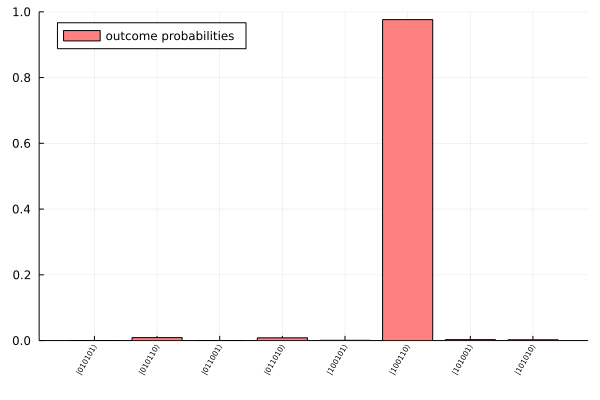

In [7]:
plot_circuit_output_distribution(circ_opt1, ψ_initial(3, 2))

The plot should show high probability mass on one or both of the states $|011001\rangle$ and $|100110\rangle$, which are the two optimal solutions. We can also print out the probabilities of the individual solutions:

In [8]:
# Prints a sorted list of output colorings.
# - first element is the coloring
# - second element is the objective function value for this coloring
# - third element is its probability in the output superposition
output_colorings_distribution_scored(circ_opt1, exampleGraph1)

8-element Vector{Tuple{Vector{Int64}, Int64, Float64}}:
 ([1, 2, 1], 2, 0.9762222572429431)
 ([2, 2, 1], 1, 0.009091816277512694)
 ([2, 1, 1], 1, 0.008398364835496063)
 ([1, 1, 2], 1, 0.0028366812315051932)
 ([1, 1, 1], 0, 0.0024515400845153746)
 ([1, 2, 2], 1, 0.0009337333185268524)
 ([2, 2, 2], 0, 5.505109225048016e-5)
 ([2, 1, 2], 2, 1.0555917250003167e-5)

### Experiment 2
Next, we'll run the QAOA optimization on a slightly bigger graph $(n = 5)$ with two colors ($\kappa = 2$). This gives $5 \cdot 2 = 10$ qubits, which is already close to the maximum number of qubits we can handle without running out of memory.


This example is more interesting, because the graph is not 2-colorable. It can be made 2-colorable by removing one edge, so the maximum objective function value is 5.0. The algorithm should be able to approach this optimum, however it might take more iterations than before. Also the example takes a while to run, because of the increased number of qubits.

In [9]:
exampleGraph2 = Graph(5, [(1,2), (2,3), (3,4), (4,5), (5,1), (1,3)]);
κ = 2 # number of colors
p = 5 # number of phase separator/mixer pairs in the circuit (depth)

# This might take a while...
circ_opt2 = optimize_qaoa(exampleGraph2, κ, p=p, training_rounds=30, mixer_type=RNearbyValuesMixerGate)

Training, round 1: average objective = 2.727881693018363
Training, round 2: average objective = 2.8993197373790798
Training, round 3: average objective = 3.0543903877796823
Training, round 4: average objective = 3.1922510192910134
Training, round 5: average objective = 3.3222718834594382
Training, round 6: average objective = 3.451289982004087
Training, round 7: average objective = 3.5729941654062767
Training, round 8: average objective = 3.67446343433732
Training, round 9: average objective = 3.7481543066201954
Training, round 10: average objective = 3.7987592851355925
Training, round 11: average objective = 3.8397606224563594
Training, round 12: average objective = 3.883840756628966
Training, round 13: average objective = 3.9391345018267687
Training, round 14: average objective = 4.009252953992526
Training, round 15: average objective = 4.093104619217364
Training, round 16: average objective = 4.186777398791515
Training, round 17: average objective = 4.2860084632700755
Training, roun


   10 ——□—————□—————□—————□—————□—————□—————□—————□—————□—————□———
        |     |     |     |     |     |     |     |     |     |   
    9 ——□—————□—————□—————□—————□—————□—————□—————□—————□—————□———
        |           |           |           |           |         
    8 ——□—————□—————□—————□—————□—————□—————□—————□—————□—————□———
        |     |     |     |     |     |     |     |     |     |   
    7 ——□—————□—————□—————□—————□—————□—————□—————□—————□—————□———
        |           |           |           |           |         
    6 ——□—————□—————□—————□—————□—————□—————□—————□—————□—————□———
        |     |     |     |     |     |     |     |     |     |   
    5 ——□—————□—————□—————□—————□—————□—————□—————□—————□—————□———
        |           |           |           |           |         
    4 ——□—————□—————□—————□—————□—————□—————□—————□—————□—————□———
        |     |     |     |     |     |     |     |     |     |   
    3 ——□—————□—————□—————□—————□—————□—————□—————□—————□————

Let's look at the output distribution:

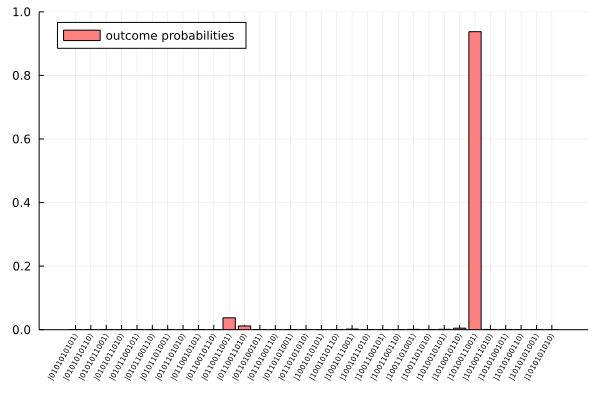

In [10]:
plot_circuit_output_distribution(circ_opt2, ψ_initial(5, 2))

In [11]:
output_colorings_distribution_scored(circ_opt2, exampleGraph2)

32-element Vector{Tuple{Vector{Int64}, Int64, Float64}}:
 ([1, 1, 2, 1, 2], 5, 0.937506346620667)
 ([2, 1, 2, 1, 2], 4, 0.03737032578590357)
 ([2, 1, 2, 1, 1], 4, 0.011739034580175478)
 ([1, 1, 2, 2, 1], 3, 0.004876894370098643)
 ([1, 2, 2, 1, 2], 5, 0.0019251763331803071)
 ([1, 1, 2, 2, 2], 3, 0.001315080489722168)
 ([1, 2, 1, 1, 2], 4, 0.0010612050057217308)
 ([1, 1, 2, 1, 1], 3, 0.0008833103868189397)
 ([1, 1, 1, 2, 2], 2, 0.0007961441519853345)
 ([2, 1, 1, 1, 2], 3, 0.0006785462685169906)
 ([2, 2, 2, 1, 2], 2, 0.0005001156563968882)
 ([1, 1, 1, 1, 2], 2, 0.00033108287984116207)
 ([2, 1, 1, 2, 2], 3, 0.0003310513098967334)
 ⋮
 ([2, 2, 1, 1, 1], 3, 1.3977277307374275e-5)
 ([2, 1, 1, 2, 1], 5, 1.3821938202733061e-5)
 ([1, 1, 1, 1, 1], 0, 1.0848611501949055e-5)
 ([1, 2, 2, 2, 1], 3, 1.066464802248452e-5)
 ([2, 2, 1, 2, 2], 3, 7.103282748260131e-6)
 ([1, 1, 1, 2, 1], 2, 6.384968454605994e-6)
 ([1, 2, 1, 2, 1], 4, 4.8824356099254935e-6)
 ([1, 2, 1, 1, 1], 2, 3.111981181915231e-6)
 ([1, 2

You should see that high probability mass is put on one or more colorings with objective function value 5.